# Toy example for stimulation 

### Van der Pol oscillator example

This code is a modified version of the one in https://github.com/pearsonlab/Bubblewrap/blob/main/datagen.py

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# Define the Van der Pol oscillator function
def vdp(t, f, mu=1.0):
    x, y = f
    x_dot = y
    y_dot = mu * (1 - x**2) * y - x
    return [x_dot, y_dot]

In [4]:
# Define the random projection function
def random_proj(initial_dim: int, dim: int, seed=4):
    rand = np.random.default_rng(seed)
    t = rand.normal(0, 1, size=(dim, initial_dim))
    return (t / np.sum(t, axis=0)).T


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


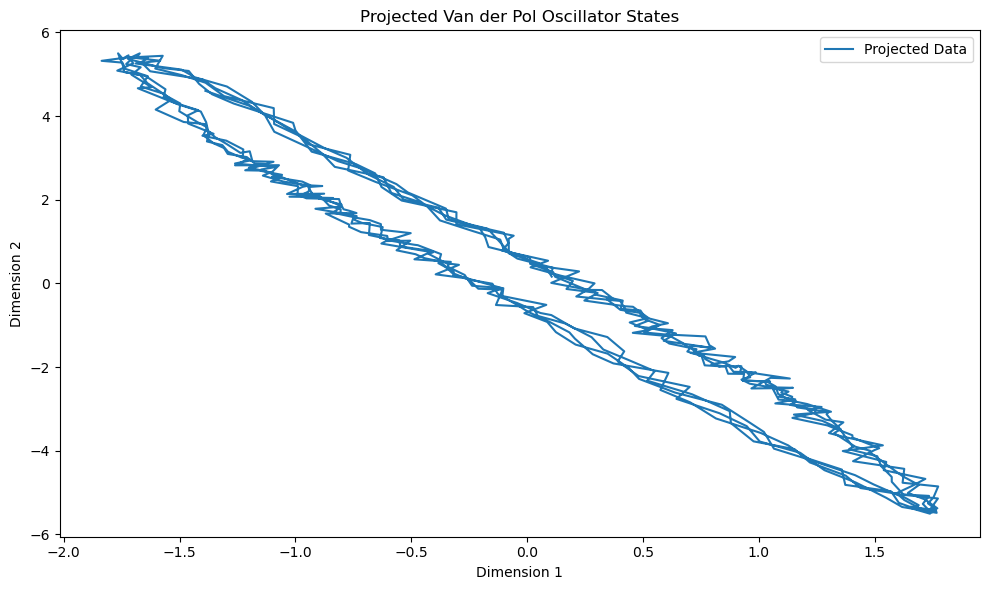

In [83]:
# Define the data generation function
def gen_data_diffeq(f, projection, t, x0, dim, ivp_kwargs=None, proj_kwargs=None, noise=None, noise_kwargs=None, seed=41):
    if ivp_kwargs is None:
        ivp_kwargs = {}
    if proj_kwargs is None:
        proj_kwargs = {}
    if noise_kwargs is None:
        noise_kwargs = {}
        
    ivp = solve_ivp(f, t, x0, rtol=1e-6, **ivp_kwargs)
    
    y = ivp['y'].T
    proj = projection(y.shape[1], dim, **proj_kwargs)
    projed = y @ proj
    
    if noise is not None:
        rand = np.random.default_rng(seed)
        projed += getattr(rand, noise)(**noise_kwargs, size=projed.shape)
    
    return ivp['t'], y, projed

# Define the function to generate datasets
def make_dataset(f, x0, num_trajectories, num_dim, begin, end, noise):
    xx = []
    projeds = []
    rng = np.random.RandomState(39)
    
    for _ in trange(num_trajectories):
        t, x, projed = gen_data_diffeq(f, random_proj,
                                       t=(0, 125), x0=x0 + 0.01 * rng.randn(*x0.shape), dim=num_dim, noise="normal",
                                       ivp_kwargs={'max_step': 0.05},
                                       noise_kwargs={"loc": 0, "scale": noise},)
        t = t[begin:end]
        xx.append(x[begin:end])
        projeds.append(projed[begin:end])
    
    xx = np.stack(xx, axis=0)
    projeds = np.stack(projeds, axis=0)
    
    xs = xx
    ys = projeds
    us = np.zeros((xx.shape[0], xx.shape[1], 1))
    
    return xs, ys

# Generate data using the Van der Pol oscillator
x0 = np.array([0.1, 0.1])
num_trajectories = 1
num_dim = 2
begin, end = 500, 1050
noise = 0.05

xs, ys = make_dataset(vdp, x0, num_trajectories, num_dim, begin, end, noise)

# Plot the results
plt.figure(figsize=(10, 6))

"""
# Plot the original Van der Pol states
plt.subplot(2, 1, 1)
plt.plot(xs[0, :, 0], xs[0, :, 1], label='Van der Pol Oscillator')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Van der Pol Oscillator States')
plt.legend()
"""
# Plot the projected states
plt.subplot(1, 1, 1)
plt.plot(ys[0, :, 0], ys[0, :, 1], label='Projected Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projected Van der Pol Oscillator States')
plt.legend()

plt.tight_layout()
plt.show()

## Define the type of impulse stimulation

In [68]:
# Add a funtion for stimulation
# an impulse function that starts at start_time and decays exponentialy with decay_rate
def stimulation(t, start_time, amplitude, decay_rate):
    if t < start_time:
        return 0
    return amplitude * np.exp(-decay_rate * (t - start_time))

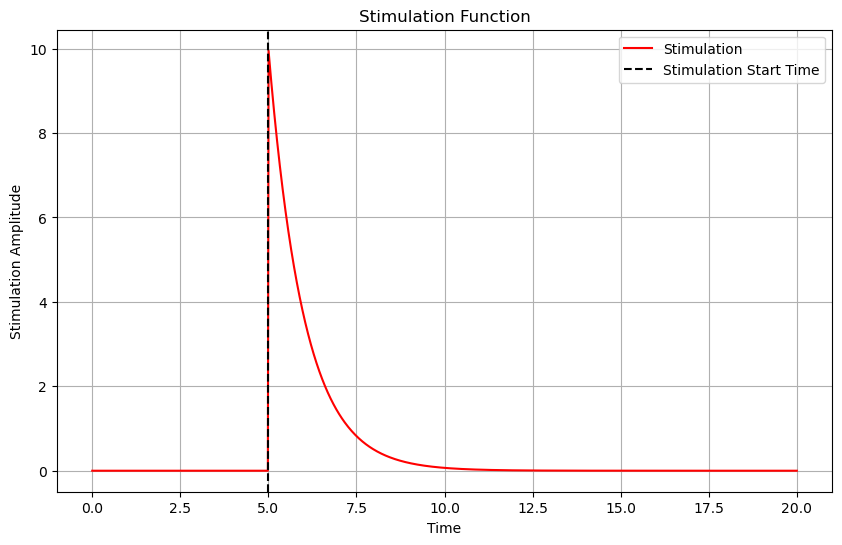

In [69]:
#Visualize the stimulation function
# Parameters for the stimulation
start_time = 5.0
amplitude = 10.0
decay_rate = 1.0
time_duration = 20.0

# Generate time points
t_values = np.linspace(0, time_duration, 1000)

# Compute stimulation values
stim_values = [stimulation(t, start_time, amplitude, decay_rate) for t in t_values]

# Plot the stimulation function
plt.figure(figsize=(10, 6))
plt.plot(t_values, stim_values, label='Stimulation', color='red')
plt.axvline(x=start_time, color='black', linestyle='--', label='Stimulation Start Time')
plt.xlabel('Time')
plt.ylabel('Stimulation Amplitude')
plt.title('Stimulation Function')
plt.legend()
plt.grid(True)
plt.show()

## Implement the stimulation within the generated data

In [78]:
# Define the data generation function with stimulation
def gen_data_diffeq(f, projection, t, x0, dim, ivp_kwargs=None, proj_kwargs=None, noise=None, noise_kwargs=None, seed=41,
                    stim_start_time=0, stim_amplitude=1.0, stim_decay_rate=0.1):
    if ivp_kwargs is None:
        ivp_kwargs = {}
    if proj_kwargs is None:
        proj_kwargs = {}
    if noise_kwargs is None:
        noise_kwargs = {}
        
    ivp = solve_ivp(f, t, x0, rtol=1e-6, **ivp_kwargs)
    
    y = ivp['y'].T
    proj = projection(y.shape[1], dim, **proj_kwargs)
    projed = y @ proj
    
    if noise is not None:
        rand = np.random.default_rng(seed)
        projed += getattr(rand, noise)(**noise_kwargs, size=projed.shape)
    
    # Apply stimulation to the projected data
    stim = np.array([stimulation(ti, stim_start_time, stim_amplitude, stim_decay_rate) for ti in ivp['t']])
    projed[:, 0] += stim  # Assuming the stimulation affects the first dimension
    
    return ivp['t'], y, projed

# Define the function to generate datasets
def make_dataset(f, x0, num_trajectories, num_dim, begin, end, noise, stim_timestep=600, stim_amplitude=1.0, stim_decay_rate=0.1):
    xx = []
    projeds = []
    rng = np.random.RandomState(39)
    
    for _ in trange(num_trajectories):
        t, x, projed = gen_data_diffeq(f, random_proj,
                                       t=(0, 125), x0=x0 + 0.01 * rng.randn(*x0.shape), dim=num_dim, noise="normal",
                                       ivp_kwargs={'max_step': 0.05},
                                       noise_kwargs={"loc": 0, "scale": noise},
                                       stim_start_time=0, stim_amplitude=0, stim_decay_rate=0)
        t = t[begin:end]
        # Calculate the actual start time for stimulation
        stim_start_time = t[stim_timestep - begin]
        # Regenerate the data with the correct stimulation start time
        t, x, projed = gen_data_diffeq(f, random_proj,
                                       t=(0, 125), x0=x0 + 0.01 * rng.randn(*x0.shape), dim=num_dim, noise="normal",
                                       ivp_kwargs={'max_step': 0.05},
                                       noise_kwargs={"loc": 0, "scale": noise},
                                       stim_start_time=stim_start_time, stim_amplitude=stim_amplitude, stim_decay_rate=stim_decay_rate)
        t = t[begin:end]
        xx.append(x[begin:end])
        projeds.append(projed[begin:end])
    
    xx = np.stack(xx, axis=0)
    projeds = np.stack(projeds, axis=0)
    
    xs = xx
    ys = projeds
    us = np.zeros((xx.shape[0], xx.shape[1], 1))
    
    return xs, ys


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


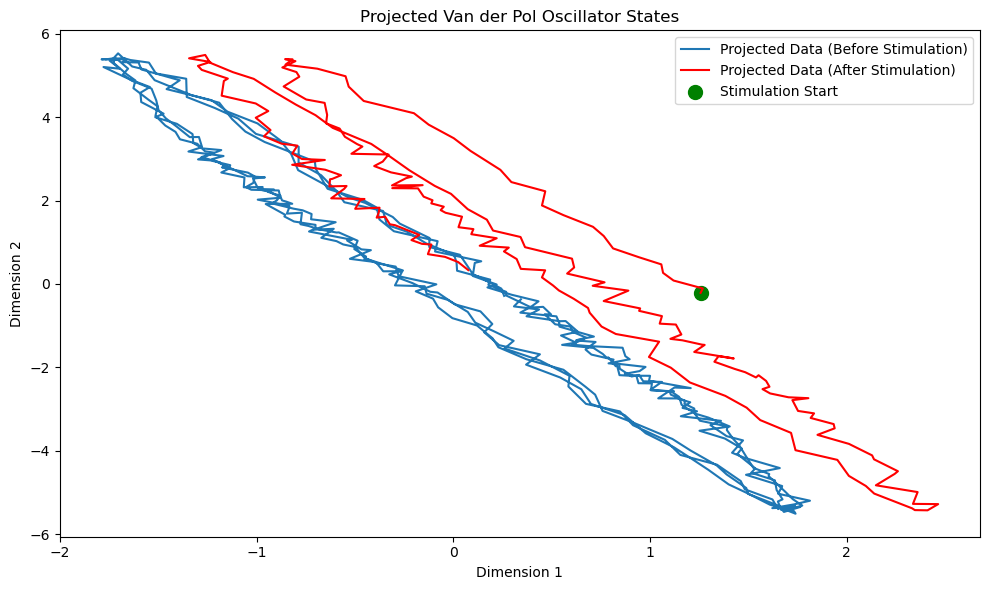

In [79]:
# Generate data using the Van der Pol oscillator with stimulation
x0 = np.array([0.1, 0.1])
num_trajectories = 1
num_dim = 2
begin, end = 500, 1100
noise = 0.05
stim_timestep = 900
stim_amplitude = 1.0
stim_decay_rate = 0.1

xs, ys = make_dataset(vdp, x0, num_trajectories, num_dim, begin, end, noise, stim_timestep, stim_amplitude, stim_decay_rate)

# Plot the results
plt.figure(figsize=(10, 6))

# Find the index where stimulation starts
stim_index = stim_timestep - begin

# Plot the projected states
plt.plot(ys[0, :stim_index, 0], ys[0, :stim_index, 1], label='Projected Data (Before Stimulation)')
plt.plot(ys[0, stim_index:, 0], ys[0, stim_index:, 1], label='Projected Data (After Stimulation)', color='red')

# Plot a green dot where the red plot starts
plt.scatter(ys[0, stim_index, 0], ys[0, stim_index, 1], color='green', s=100, label='Stimulation Start')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projected Van der Pol Oscillator States')
plt.legend()

plt.tight_layout()
plt.show()

100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


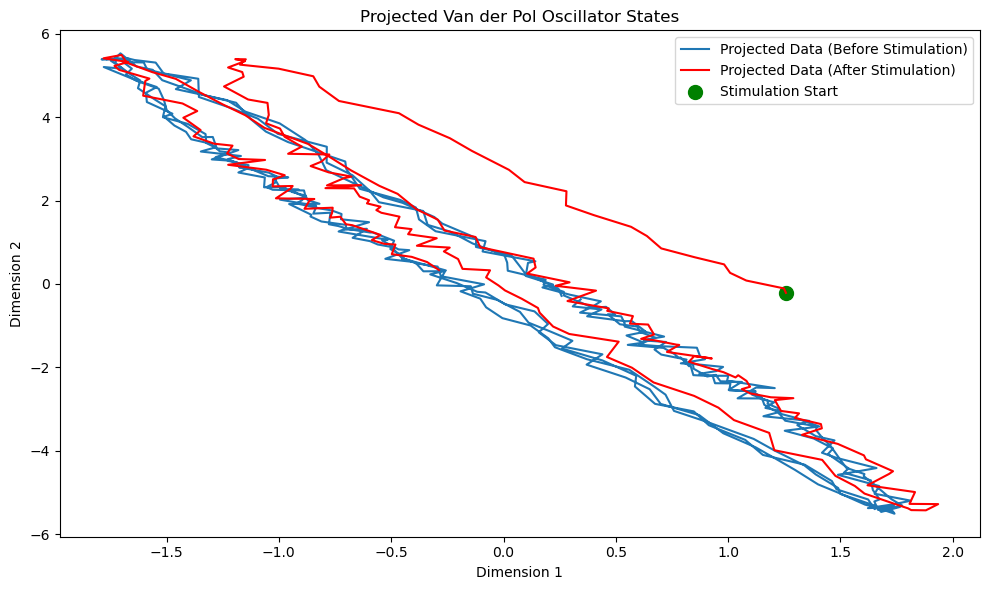

In [80]:
# Generate data using the Van der Pol oscillator with stimulation
x0 = np.array([0.1, 0.1])
num_trajectories = 1
num_dim = 2
begin, end = 500, 1100
noise = 0.05
stim_timestep = 900
stim_amplitude = 1.0
stim_decay_rate = .5

xs, ys = make_dataset(vdp, x0, num_trajectories, num_dim, begin, end, noise, stim_timestep, stim_amplitude, stim_decay_rate)

# Plot the results
plt.figure(figsize=(10, 6))

# Find the index where stimulation starts
stim_index = stim_timestep - begin

# Plot the projected states
plt.plot(ys[0, :stim_index, 0], ys[0, :stim_index, 1], label='Projected Data (Before Stimulation)')
plt.plot(ys[0, stim_index:, 0], ys[0, stim_index:, 1], label='Projected Data (After Stimulation)', color='red')

# Plot a green dot where the red plot starts
plt.scatter(ys[0, stim_index, 0], ys[0, stim_index, 1], color='green', s=100, label='Stimulation Start')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Projected Van der Pol Oscillator States')
plt.legend()

plt.tight_layout()
plt.show()